In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# 3) Data processing

In [2]:
movie_df = pd.read_csv('data/movies.txt', delimiter='\t', header=None,
                       names=["Movie Id", "Movie Title", "Unknown", "Action", 
                              "Adventure", "Animation", "Childrens", "Comedy", 
                              "Crime", "Documentary", "Drama", "Fantasy", 
                              "Film-Noir", "Horror", "Musical", "Mystery", 
                              "Romance", "Sci-Fi", "Thriller", "War", 
                              "Western"])

data_df = pd.read_csv('data/data.txt', delimiter='\t', header=None,
                      names=["User Id", "Movie Id", "Rating"])

### Clean Data

In [3]:
# Get rid of duplicate movies
for title, sub_df in movie_df.groupby(['Movie Title']):
    if (len(sub_df) > 1):
        # Get of equivalent ids along with representative (lowest id)
        eq_ids, rep = set(sub_df["Movie Id"]), sub_df["Movie Id"].values[0]
        data_df.loc[data_df["Movie Id"].isin(eq_ids), "Movie Id"] = rep

cols = list(movie_df.columns); cols.remove("Movie Id")
movie_df = movie_df.drop_duplicates(subset = cols, keep='first')

# Get rid of movies with no reviews
reviewed = set(movie_df["Movie Id"]).intersection(set(data_df["Movie Id"]))
movie_df = movie_df.loc[movie_df["Movie Id"].isin(reviewed), :]

# Make sure it worked?
assert(len(set(movie_df["Movie Title"])) == len(movie_df))
assert(set(movie_df["Movie Id"]) == set(data_df["Movie Id"]))

### Reset Ids

In [4]:
movie_df = movie_df.reset_index(drop=True)
to_replace = {Id: index for Id, index in zip(movie_df["Movie Id"], movie_df.index)}
movie_df["Movie Id"] = movie_df["Movie Id"].map(to_replace)
data_df["Movie Id"] = data_df["Movie Id"].map(to_replace)
movie_df.tail(3) # Make sure Movie Id col and actual id's line up

,Movie Id,Movie Title,Unknown,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
1661,1661,B. Monkey (1998),0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1662,1662,You So Crazy (1994),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1663,1663,Scream of Stone (Schrei aus Stein) (1991),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 4) Basic Visualization

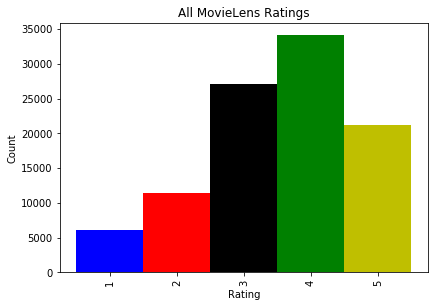

In [16]:
hist_vals = data_df["Rating"].value_counts().sort_index()
hist_vals.plot(kind="bar", width=1.0, color=['b', 'r', 'k', 'g', 'y'])
plt.tight_layout(); plt.xlabel("Rating"); plt.ylabel("Count");
plt.title('All MovieLens Ratings');

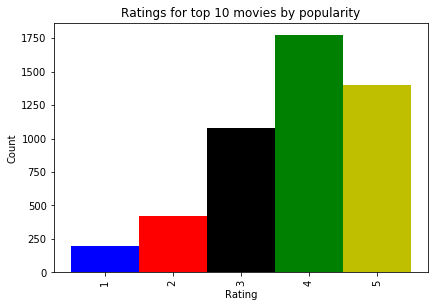

In [28]:
nMovies = 10
pop_movs = data_df["Movie Id"].value_counts()[:nMovies].index
ratings = data_df.loc[data_df["Movie Id"].isin(pop_movs), "Rating"]

# histogram the ratings
hist_vals = ratings.value_counts().sort_index()
hist_vals.plot(kind="bar", width=1.0, color=['b', 'r', 'k', 'g', 'y'])
plt.tight_layout(); plt.xlabel("Rating"); plt.ylabel("Count");
plt.title(f'Ratings for top {nMovies} movies by popularity');

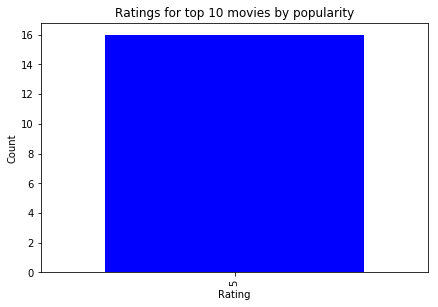

In [41]:
nMovies = 10
av_ratings = data_df.groupby("Movie Id").aggregate('mean')
sort_ratings = av_ratings.sort_values(by='Rating', axis='index', ascending=False)
best_movs = sort_ratings[:nMovies].index
ratings = data_df.loc[data_df["Movie Id"].isin(best_movs), "Rating"]

# histogram the ratings
hist_vals = ratings.value_counts().sort_index()
hist_vals.plot(kind="bar", width=1.0, color=['b', 'r', 'k', 'g', 'y'])
plt.tight_layout(); plt.xlabel("Rating"); plt.ylabel("Count");
plt.title(f'Ratings for top {nMovies} movies by rating');

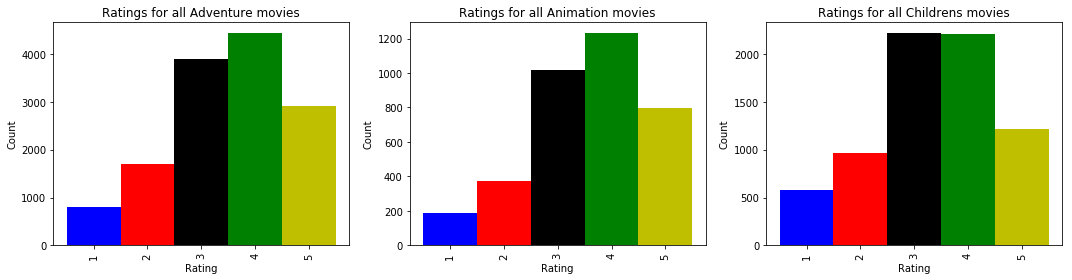

In [49]:
genres = ["Adventure", "Animation", "Childrens"]
fig, axes = plt.subplots(1, len(genres), figsize = (5 * len(genres), 4))

for ax, genre in zip(axes, genres):
    ids = movie_df.loc[movie_df[genre] == 1, "Movie Id"]
    ratings = data_df.loc[data_df["Movie Id"].isin(ids), "Rating"]
    hist_vals = ratings.value_counts().sort_index()
    hist_vals.plot(kind="bar", width=1.0, color=['b', 'r', 'k', 'g', 'y'], ax=ax)
    ax.set_xlabel("Rating"); ax.set_ylabel("Count");
    ax.set_title(f'Ratings for all {genre} movies');
    
plt.tight_layout();